In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

# import multiprocessing

# np.random.seed(114514)
# xp.random.seed(114514)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


has cupy
has cupy
has BBHx waveform


## Data settings 

In [3]:
t_start = 10. * DAY # start time in s
Tobs = 5. * DAY # data length in s 
t_end = t_start + Tobs # end time in s 
dt = 10. # time cadance in s 
fsample = 1. / dt # sampling rate in Hz 
data_frequencies = np.fft.rfftfreq(n=int(Tobs/dt), d=dt) # frequecies where waveform will be calculated 
delta_f = 1. / Tobs

data_frequencies.shape 

(21601,)

In [4]:
# mask the "null" frequencies, which may cause singularity in the calculation of likelihood 
mask = np.ones_like(data_frequencies, dtype=bool)
for i in range(1, 40): 
    mask_idx = np.where(np.abs(data_frequencies - i*0.025)<i*3e-4)[0]
    mask[mask_idx] = False 
data_frequencies = data_frequencies[mask]

# remove the frequencies below Taiji sensitive band 
mask = np.where(data_frequencies > 1e-5)[0]
data_frequencies = data_frequencies[mask]
data_frequencies_GPU = xp.array(data_frequencies)

data_frequencies.shape 

(21077,)

## Set response model 

In [5]:
# the path of Taiji orbit 
orbit_GPU = Orbit(OrbitDir="../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB") # create individial orbit objects for CPU and GPU to avoid the confusion of numpy / cupy orbit data 

# initialize  waveform generator 
WFG_GPU = BBHxWaveformGenerator(mode="primary", use_gpu=True)

# initialize response generator 
FDTDI_GPU = BBHxFDTDIResponseGenerator(orbit_class=orbit_GPU, waveform_generator=WFG_GPU, use_gpu=True)

# response settings 
response_kwargs_GPU = dict(
    modes=[(2,2)], 
    tmin=t_start / DAY, # start time in day 
    tmax=t_end / DAY, # end time in day  
    TDIGeneration="2nd", # "1st" or "2nd"
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
    interpolation=True,
)

## Waveform generation 

In [6]:
mbhb_parameters = {
    'chirp_mass': np.power(10., np.random.uniform(5.5, 6.5)), # [Solar mass], for chirp_mass of 10^5 or smaller, a smaller dt is needed
    'mass_ratio': np.random.uniform(0.1, 1.), 
    'spin_1z': np.random.uniform(-0.99, 0.99),
    'spin_2z': np.random.uniform(-0.99, 0.99),
    'coalescence_time': np.random.uniform(t_start + 3. * DAY, t_end) / DAY, # [day], start from t_start to ensure that at least 3-day waveform is within the data
    'coalescence_phase': np.random.uniform(0, TWOPI),
    'luminosity_distance': np.power(10., np.random.uniform(4., 5.)), # [MPC]
    'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    'longitude': np.random.uniform(0, TWOPI), # [rad]
    'latitude': np.arcsin(np.random.uniform(-1., 1.)), # [rad]
    'psi': np.random.uniform(0, PI) # [rad]
    }
mbhb_parameters

{'chirp_mass': 1150299.299330668,
 'mass_ratio': 0.2536463799924332,
 'spin_1z': 0.3678983609142428,
 'spin_2z': 0.7958377032692865,
 'coalescence_time': 14.049072610976467,
 'coalescence_phase': 3.66372008915396,
 'luminosity_distance': 14847.035532947599,
 'inclination': 1.2803043092596742,
 'longitude': 3.231097113709258,
 'latitude': -0.22119219682355637,
 'psi': 1.8387734921297747}

In [7]:
wf_channels = FDTDI_GPU.Response(mbhb_parameters, data_frequencies_GPU, **response_kwargs_GPU)
wf_channels.shape 

(3, 21077)

## Noise generation 

In [8]:
arm_time = (t_start + t_end) / 2. 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit_GPU.LTTfunctions()[key](arm_time)
# print("arm lengths:", arms)

# theoretical PSDs at the given armlengths 
PSDfunc = TDIPSDs()
PSD_channels = np.array([
    PSDfunc.PSD_A2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_E2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_T2_unequal(data_frequencies, arms)
])

# generate frequency-domain noises as Gaussian and stationary 
Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
noise_channels = xp.array(Re_tmp + 1.j * Im_tmp) 

# covariance matrix 
CovMat = np.array([
    [PSD_channels[0], np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), PSD_channels[1], np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = np.linalg.inv(np.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)
InvCovMat[:, 2, 2] *= 0. # use A, E channels only in the following analysis 

PSD_channels.shape, noise_channels.shape, InvCovMat.shape 

((3, 21077), (3, 21077), (21077, 3, 3))

In [9]:
opt_SNR = FrequencyDomainCovarianceSNR(wf_channels.get(), InvCovMat)
opt_SNR

1177.048967636147

## Data combination 

In [10]:
data_channels = wf_channels + noise_channels 

Text(0, 0.5, 'Frequency-domain data (1/Hz)')

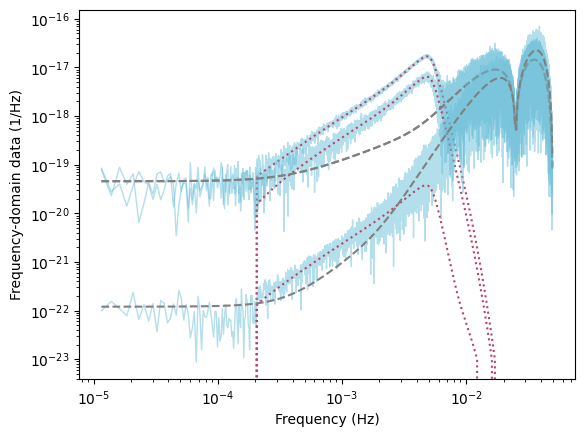

In [11]:
for ichannel, nchannel in enumerate(["A", "E", "T"]): 
    plt.loglog(data_frequencies, np.abs(data_channels[ichannel].get()), linewidth=1, alpha=0.5, color=BLUE)
    plt.loglog(data_frequencies, np.abs(wf_channels[ichannel].get()), color=RED, linestyle=":")
    plt.loglog(data_frequencies, np.sqrt(PSD_channels[ichannel] * Tobs / 2.), color="grey", linestyle="--")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency-domain data (1/Hz)")

## Rapid search phase 

### initialize $\mathcal{F}$-stat and likelihood

In [12]:
Fstat = Fstatistics(
    response_generator=FDTDI_GPU, 
    frequency=data_frequencies_GPU, 
    data=data_channels, 
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_GPU, 
    use_gpu=True 
)

Like = Likelihood(
    response_generator=FDTDI_GPU, 
    frequency=data_frequencies_GPU, 
    data=data_channels,
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_GPU, 
    use_gpu=True,
)

number of freuqncies: 21077
min and max frequencies: 1.1574074074074073e-05 0.04939814814814815
response kwargs: {'modes': [(2, 2)], 'tmin': 10.0, 'tmax': 15.0, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False, 'interpolation': True}
number of freuqncies: 21077
min and max frequencies: 1.1574074074074073e-05 0.04939814814814815
response kwargs: {'modes': [(2, 2)], 'tmin': 10.0, 'tmax': 15.0, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False, 'interpolation': True}


### compare $\mathcal{F}$-stat and likelihood around truths

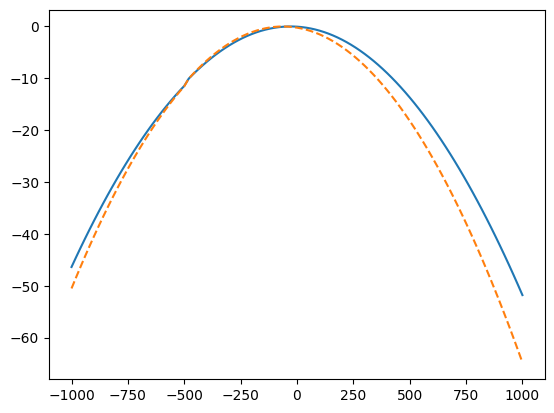

In [13]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["chirp_mass"] = mbhb_parameters["chirp_mass"] + np.linspace(-1000, 1000, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["chirp_mass"] = test_int_params["chirp_mass"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["chirp_mass"] - mbhb_parameters["chirp_mass"], test_F - np.max(test_F))
plt.plot(test_int_params["chirp_mass"] - mbhb_parameters["chirp_mass"], test_L - np.max(test_L), linestyle="--")

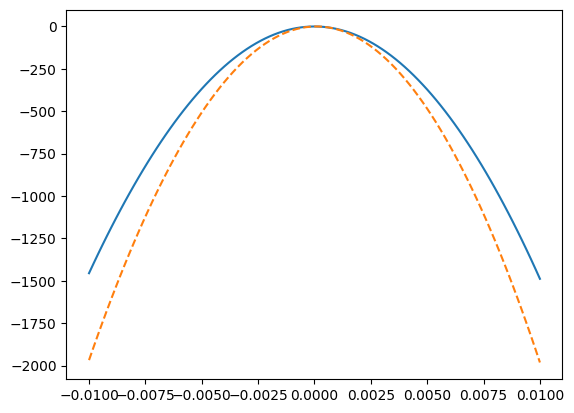

In [14]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["spin_1z"] = mbhb_parameters["spin_1z"] + np.linspace(-0.01, 0.01, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["spin_1z"] = test_int_params["spin_1z"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["spin_1z"] - mbhb_parameters["spin_1z"], test_F - np.max(test_F))
plt.plot(test_int_params["spin_1z"] - mbhb_parameters["spin_1z"], test_L - np.max(test_L), linestyle="--")

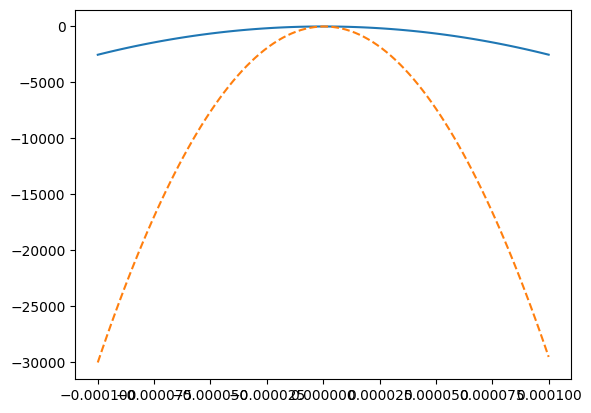

In [15]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["coalescence_time"] = mbhb_parameters["coalescence_time"] + np.linspace(-1e-4, 1e-4, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["coalescence_time"] = test_int_params["coalescence_time"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["coalescence_time"] - mbhb_parameters["coalescence_time"], test_F - np.max(test_F))
plt.plot(test_int_params["coalescence_time"] - mbhb_parameters["coalescence_time"], test_L - np.max(test_L), linestyle="--")

### test waveform and parameter recovery

In [16]:
int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    int_params.pop(key)
int_params

{'chirp_mass': 1150299.299330668,
 'mass_ratio': 0.2536463799924332,
 'spin_1z': 0.3678983609142428,
 'spin_2z': 0.7958377032692865,
 'coalescence_time': 14.049072610976467,
 'longitude': 3.231097113709258,
 'latitude': -0.22119219682355637}

In [17]:
rec_wave = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=int_params, 
    return_recovered_wave=True, 
)
rec_wave.shape

(3, 1, 21077)

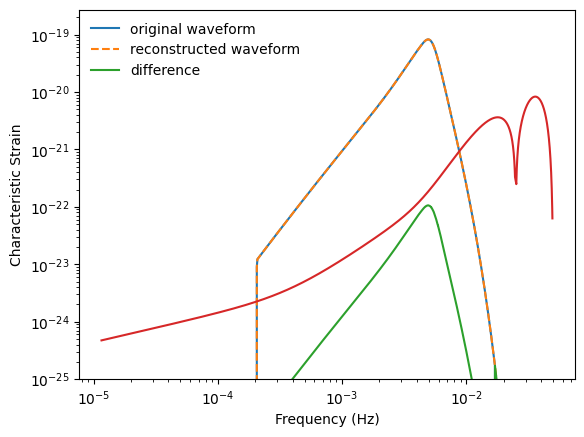

In [18]:
plt.loglog(data_frequencies, np.abs(wf_channels[0].get()) * data_frequencies, label="original waveform")
plt.loglog(data_frequencies, np.abs(rec_wave[0][0].get()) * data_frequencies, linestyle="--", label="reconstructed waveform")
plt.loglog(data_frequencies, np.abs(rec_wave[0][0].get() - wf_channels[0].get()) * data_frequencies, label="difference")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies))
plt.ylim(1e-25,)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")
plt.legend(loc="upper left", frameon=False)

In [19]:
rec_a = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=int_params, 
    return_a=True, 
)
rec_a.shape 

(1, 4)

In [20]:
rec_ext_params = Fstat.a_to_extrinsic_vectorized(rec_a)
for k, v in rec_ext_params.items():
    print(k, v, mbhb_parameters[k])

luminosity_distance 14866.738049791516 14847.035532947599
inclination 1.279930036891578 1.2803043092596742
psi 0.26641407589283 1.8387734921297747
coalescence_phase 0.5198685496733827 3.66372008915396


### optimization from prior 

In [21]:
intrinsic_parameter_ranges = np.array([
    [5.5, 6.5], 
    [0.1, 1.], 
    [-0.99, 0.99], 
    [-0.99, 0.99], 
    # [mbhb_parameters["coalescence_time"]-0.01, mbhb_parameters["coalescence_time"]+0.01], 
    [t_start / DAY + 3., t_end / DAY], 
    [0, TWOPI], 
    [-1., 1.]
])

intrinsic_parameter_ranges

array([[ 5.5       ,  6.5       ],
       [ 0.1       ,  1.        ],
       [-0.99      ,  0.99      ],
       [-0.99      ,  0.99      ],
       [13.        , 15.        ],
       [ 0.        ,  6.28318531],
       [-1.        ,  1.        ]])

In [ ]:
from scipy.optimize import differential_evolution

n_dim_int = len(Fstatistics.intrinsic_parameter_names)
print("number of parameters to be optimized:", n_dim_int)

def cost_function(norm_int_params):
    """   
        norm_int_params: shape (Nparams, Nevent), normalized to (0, 1)
    """
    int_params = norm_int_params.transpose() * (intrinsic_parameter_ranges[:, 1] - intrinsic_parameter_ranges[:, 0]) + intrinsic_parameter_ranges[:, 0] # (Nevent, Nparams)
    params_in = Fstat.IntParamArr2ParamDict(int_params.transpose()) # (Nparams, Nevent) -> dictionary, each item (Nevent)
    return -Fstat.calculate_Fstat_vectorized(intrinsic_parameters=params_in) # (Nevent)

lower_bounds = np.zeros(n_dim_int) 
upper_bounds = np.ones(n_dim_int) 
bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

DE_result = differential_evolution(
    func=cost_function,
    bounds=bounds,
    x0=None,
    strategy='best1exp',
    # strategy='rand1bin',
    maxiter=5000,
    popsize=10*n_dim_int,
    # popsize=6*n_dim_int, 
    tol=1e-7,
    atol=1e-9,
    mutation=(0.4, 0.95),
    recombination=0.7,
    disp=False,
    polish=False,
    vectorized=True,
)
print(DE_result)

number of parameters to be optimized: 7


/home/ps/miniconda3/envs/tdc/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


### reconstruct parameters and waveforms 

In [ ]:
searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_parameter_ranges[:, 1] - intrinsic_parameter_ranges[:, 0]) + intrinsic_parameter_ranges[:, 0])

searched_a = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=searched_int_params, 
    return_a=True, 
) # (1, 4)
searched_ext_params = Fstat.a_to_extrinsic_vectorized(searched_a)

searched_params = dict(searched_int_params, **searched_ext_params)

for k, v in searched_params.items():
    print(k, mbhb_parameters[k], np.abs(v-mbhb_parameters[k]))

chirp_mass 2259094.455156889 2776.8105981652625
mass_ratio 0.4444493283758254 0.0012827076374625213
spin_1z -0.2701201002084215 0.004980767358979121
spin_2z -0.9597909664350507 0.030188520766064042
coalescence_time 14.491723983336165 0.0015856410498589213
longitude 2.9427493492299055 0.27580812280396794
latitude -0.05649269163420212 0.10263348572703268
luminosity_distance 48559.85727298156 33373.25368583175
inclination 1.171165748725821 0.247808398921874
psi 3.0246186778975277 2.694483832475559
coalescence_phase 2.8443708166072743 2.361511072748534


(3, 21077)

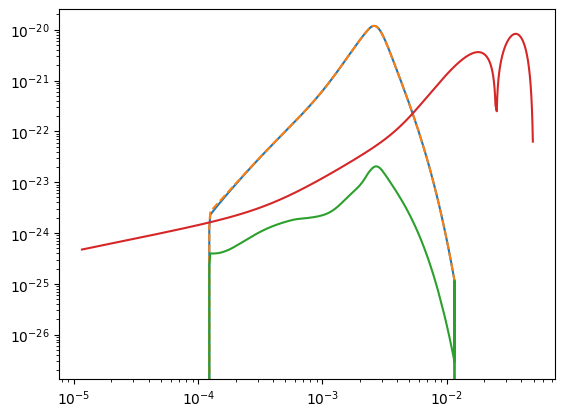

In [ ]:
# searched_wf = Fstat.calculate_Fstat_vectorized(
#     intrinsic_parameters=searched_int_params, 
#     return_recovered_wave=True
# )

searched_wf = FDTDI_GPU.Response(
    searched_params, 
    data_frequencies_GPU, 
    **response_kwargs_GPU, 
)

plt.loglog(data_frequencies, np.abs(wf_channels[0].get()) * data_frequencies)
plt.loglog(data_frequencies, np.abs(searched_wf[0].get()) * data_frequencies, linestyle="--")
plt.loglog(data_frequencies, np.abs(searched_wf[0].get() - wf_channels[0].get()) * data_frequencies, linestyle="-")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies))

searched_wf.shape 

## Fisher analysis 

In [ ]:
def fisher_waveform_wrapper(param_dict, frequencies):
    res = FDTDI_GPU.Response(
        parameters=param_dict, 
        freqs=xp.array(frequencies),  
        **response_kwargs_GPU, 
    )
    return res.get()

# set initial steps 
analyze_param_step_dict = {
    'chirp_mass': 10.,
    'mass_ratio': 0.01,
    'spin_1z': 0.01,
    'spin_2z': 0.01,
    'coalescence_time': 0.001,
    'coalescence_phase': 0.001,
    'luminosity_distance': 10.,
    'inclination': 0.01,
    'longitude': 0.01,
    'latitude': 0.01,
    'psi': 0.01
    }
for k, v in analyze_param_step_dict.items():
    analyze_param_step_dict[k] = -v 

FIM = MultiChannelFisher(
    waveform_generator=fisher_waveform_wrapper, 
    # param_dict=mbhb_parameters, 
    param_dict=searched_params, 
    analyze_param_step_dict=analyze_param_step_dict, 
    frequency=data_frequencies, 
    inverse_covariance=InvCovMat, 
    verbose=1,
)

FIM.auto_test_step()
FIM.calculate_Fisher()
FIM.calculate_errors() 

11 parameters in total: ['chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'longitude', 'latitude', 'luminosity_distance', 'inclination', 'psi', 'coalescence_phase']
11 analyzed parameters: ['chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'luminosity_distance', 'inclination', 'longitude', 'latitude', 'psi']
parameters whose steps should be tested: ['chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'luminosity_distance', 'inclination', 'longitude', 'latitude', 'psi']

 ========= testing parameter chirp_mass ==========
error = 28.20614590483932
shift = 5.0 relative diff = 5.098830943393874e-07
shift of parameter chirp_mass is 5.0

 ========= testing parameter mass_ratio ==========
error = 0.022071466194593402
shift = 0.005 relative diff = 0.002078570664942553
error = 0.022026120820104644
shift = 0.0025 relative diff = 0.0025891783523780475
error = 0.02200292530678948
shift = 0.00125 re

In [ ]:
FIM.param_errors

{'chirp_mass': 4072.8398197463944,
 'mass_ratio': 0.008527647129988134,
 'spin_1z': 0.06883821142073283,
 'spin_2z': 0.17704148284079177,
 'coalescence_time': 0.0004572443856150119,
 'coalescence_phase': 0.29952010474577845,
 'luminosity_distance': 9947.618960121172,
 'inclination': 0.10906422371379548,
 'longitude': 0.07982846233552772,
 'latitude': 0.14184463060665387,
 'psi': 0.08013628181511899}

## The 1st heterodyned search 

In [ ]:
Like.prepare_het_log_like(
    base_parameters=ParamDict2ParamArr(searched_params), 
    # base_waveform=searched_wf[:, 0, :]
    ) 

In [ ]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove
from eryn.utils.utility import groups_from_inds
from eryn.backends import HDFBackend
from eryn.utils import SearchConvergeStopping

from corner import corner

In [ ]:
truths = np.array(ParamDict2ParamArr(searched_params)) # actually the searched values 
ground_truths = np.array(ParamDict2ParamArr(mbhb_parameters))
labels = np.array(list(mbhb_parameters.keys()))
fim_range = []
for par in labels:
    if par in ["chirp_mass", "luminosity_distance"]:
        ran = FIM.param_errors[par] / searched_params[par] # log value 
    else:
        ran = FIM.param_errors[par] # we donot process the sin/cos values since they will not be used 
    fim_range.append(ran)
fim_range = np.array(fim_range) * 10. # ~10 sigmas

for idx, par in enumerate(labels):
    print(par, truths[idx], fim_range[idx])

chirp_mass 6.353400239623454 0.018050826440897397
mass_ratio 0.4431666207383629 0.08527647129988133
spin_1z -0.26513933284944236 0.6883821142073283
spin_2z -0.9899794872011147 1.7704148284079178
coalescence_time 14.490138342286306 0.004572443856150119
coalescence_phase 0.4828597438587405 2.9952010474577846
luminosity_distance 4.181460656792998 6.550259182730219
inclination 0.15123960142371884 1.090642237137955
longitude 3.2185574720338734 0.7982846233552772
latitude -0.15845548434922951 1.4184463060665387
psi 0.3301348454219687 0.8013628181511899


In [ ]:
# set hyper parameters
ndim = 11 # dimension of paramters 
nwalkers = 400 # number of random walkers, more walkers can be used since heterodyned likelihood requires much less vRAM, 400 is a quite large number for this task 
ntemps = 10 # number of temperatures used in parallel tempering 
temps = np.array(list(np.power(2., np.arange(ntemps - 1))) + [np.infty]) 
betas = 1. / temps 
tempering_kwargs=dict(betas=betas)

mcmc_moves = StretchMove(a=2) # emcee move 

stop = None 

# set a narrower prior for the instrinsic parameters, since heterodyned likelihood must be based on an initial estimation 
lim_lgMc = [truths[0] - fim_range[0], truths[0] + fim_range[0]]
lim_q = [max(0.1, truths[1] - fim_range[1]), min(1., truths[1] + fim_range[1])]
lim_chiz1 = [max(-0.99, truths[2] - fim_range[2]), min(0.99, truths[2] + fim_range[2])]
lim_chiz2 = [max(-0.99, truths[3] - fim_range[3]), min(0.99, truths[3] + fim_range[3])]
# lim_tc = [truths[4] - fim_range[4], truths[4] + fim_range[4]] 
lim_tc = [truths[4] - 0.01 * searched_params["chirp_mass"] / 1e6, truths[4] + 0.01 * searched_params["chirp_mass"] / 1e6] # empirical 
lim_phic = [0, TWOPI]
lim_lgD = [max(4., truths[6]-fim_range[6]), min(5., truths[6]+fim_range[6])]
lim_cosinc = [-1, 1]
lim_lam = [0, TWOPI]
lim_sinbeta = [-1, 1]
lim_psi = [0, PI]

lims = np.array([lim_lgMc, lim_q, lim_chiz1, lim_chiz2, lim_tc, lim_phic, lim_lgD, lim_cosinc, lim_lam, lim_sinbeta, lim_psi])
lower_lims = lims[:, 0]
upper_lims = lims[:, 1]

priors_in = {i: uniform_dist(lims[i][0], lims[i][1]) for i in range(ndim)}
priors = ProbDistContainer(priors_in)
priors.use_cupy = False

# set starting range 
# start_lims = np.array(truths)[:, np.newaxis] + np.array([-1e-3, 1e-3])
start_lims = lims.copy()
start_priors_in = {i: uniform_dist(start_lims[i][0], start_lims[i][1]) for i in range(ndim)}
start_priors = ProbDistContainer(start_priors_in)
start_priors.use_cupy = False

lims, start_lims

(array([[ 6.33534941,  6.37145107],
        [ 0.35789015,  0.52844309],
        [-0.95352145,  0.42324278],
        [-0.99      ,  0.78043534],
        [14.46757517, 14.51270152],
        [ 0.        ,  6.28318531],
        [ 3.        , 10.73171984],
        [-1.        ,  1.        ],
        [ 0.        ,  6.28318531],
        [-1.        ,  1.        ],
        [ 0.        ,  3.14159265]]),
 array([[ 6.33534941,  6.37145107],
        [ 0.35789015,  0.52844309],
        [-0.95352145,  0.42324278],
        [-0.99      ,  0.78043534],
        [14.46757517, 14.51270152],
        [ 0.        ,  6.28318531],
        [ 3.        , 10.73171984],
        [-1.        ,  1.        ],
        [ 0.        ,  6.28318531],
        [-1.        ,  1.        ],
        [ 0.        ,  3.14159265]]))

In [ ]:
((lims.T - ground_truths)[0] < 0.).all(), ((lims.T - ground_truths)[1] > 0.).all()

(True, True)

In [ ]:
lims.T - ground_truths

array([[-0.01858498, -0.08655918, -0.68340135, -0.03020903, -0.02414882,
        -2.84437082, -1.6862774 , -1.38907806, -2.94274935, -0.94353735,
        -3.02461868],
       [ 0.01751668,  0.08399376,  0.69336288,  1.74022631,  0.02097754,
         3.43881449,  6.04544244,  0.61092194,  3.34043596,  1.05646265,
         0.11697398]])

In [ ]:
def eryn_like(params): 
    """params: numpy array of shape (Nevents, Nparams)"""
    # return Like.full_log_like_vectorized(np.transpose(params))
    return Like.het_log_like_vectorized(np.transpose(params))

In [ ]:
ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    eryn_like, 
    priors,
    args=[],
    tempering_kwargs=tempering_kwargs,
    stopping_fn=stop,
    stopping_iterations=10,
    moves=mcmc_moves,
    vectorize=True,
)

In [ ]:
# randomize starting positions throughout prior
coords = start_priors.rvs(size=(ntemps, nwalkers,))
print(coords.shape)

thin_by = 100 
burn = 0
nsteps = int(100000 / thin_by) # should be more than enough 

ensemble.stopping_fn = None

out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)

(10, 400, 11)


 74%|███████▍  | 74042/100000 [7:12:15<2:27:20,  2.94it/s]Traceback (most recent call last):
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/eryn/ensemble.py", line 1644, in __call__
    out = self.f(*args_in, **kwargs_in)
  File "/tmp/ipykernel_17349/3626440450.py", line 4, in eryn_like
    return Like.het_log_like_vectorized(np.transpose(params))
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Utils.py", line 324, in het_log_like_vectorized
    het_h = self.xp.transpose(self.response_generator.Response(
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Response.py", line 1093, in Response
    _, GTDI = self.TransferFunction(t=tgrids[mode], f=fgrids, k=k, Plm=Plm[mode], TDIGeneration=TDIGeneration, tmin=tmin, tmax=tmax)
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Response.py", line 964, in TransferFunction
    zero_inds = self.xp.where(t < tmin * DAY)
  File "/h

eryn: Exception while calling your likelihood function:
  args added: [array([[ 6.35374124,  0.44720235, -0.28747411, ...,  3.51325162,
         0.1386125 ,  0.86152393],
       [ 6.35388173,  0.44908127, -0.31451841, ...,  3.8847346 ,
         0.31963664,  1.1721678 ],
       [ 6.3507487 ,  0.44015348, -0.29361508, ...,  3.52026476,
         0.37573342,  0.79048727],
       ...,
       [ 6.34482066,  0.4917002 , -0.7996334 , ...,  2.99051597,
         0.26932735,  1.17044074],
       [ 6.35372197,  0.42944223,  0.04296217, ...,  1.12666305,
        -0.63186532,  0.7695086 ],
       [ 6.36020976,  0.5091263 ,  0.00879197, ...,  0.64984682,
         0.27729702,  1.45307553]])]
  args: []
  kwargs added: {}
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [ ]:
# resume run after the run is stopped 
thin_by =100
burn = 0
nsteps = int(150000 / thin_by) # this should be far more than enough 

out = ensemble.run_mcmc(ensemble.get_last_sample(), nsteps, burn=burn, progress=True, thin_by=thin_by)

 19%|█▉        | 28654/150000 [2:31:57<10:40:03,  3.16it/s]Traceback (most recent call last):
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/eryn/ensemble.py", line 1644, in __call__
    out = self.f(*args_in, **kwargs_in)
  File "/tmp/ipykernel_8816/3626440450.py", line 4, in eryn_like
    return Like.het_log_like_vectorized(np.transpose(params))
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Utils.py", line 350, in het_log_like_vectorized
    res = self.xp.nan_to_num(self.xp.real(-0.5 * LL1 + LL2), nan=-self.xp.infty)
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/cupy/_math/misc.py", line 422, in nan_to_num
    nan = _check_nan_inf(nan, dtype)
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/cupy/_math/misc.py", line 402, in _check_nan_inf
    elif cupy.isnan(x):
KeyboardInterrupt
 19%|█▉        | 28654/150000 [2:31:57<10:43:32,  3.14it/s]

eryn: Exception while calling your likelihood function:
  args added: [array([[ 5.72861274,  0.40206816, -0.47524219, ...,  4.21616984,
        -0.29158278,  1.27012281],
       [ 5.72898971,  0.40733303, -0.49381749, ...,  4.20213324,
        -0.28895064,  1.97834313],
       [ 5.72878215,  0.40970222, -0.52257708, ...,  4.1721298 ,
        -0.26059208,  1.36690501],
       ...,
       [ 5.72870856,  0.39414022, -0.49802282, ...,  3.89155919,
        -0.22154597,  0.53615144],
       [ 5.72445968,  0.40881692, -0.28755102, ...,  1.25928618,
        -0.35248808,  2.93544361],
       [ 5.72574535,  0.3988843 , -0.54183751, ...,  1.329263  ,
         0.45871605,  2.2264781 ]])]
  args: []
  kwargs added: {}
  kwargs: {}
  exception:


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

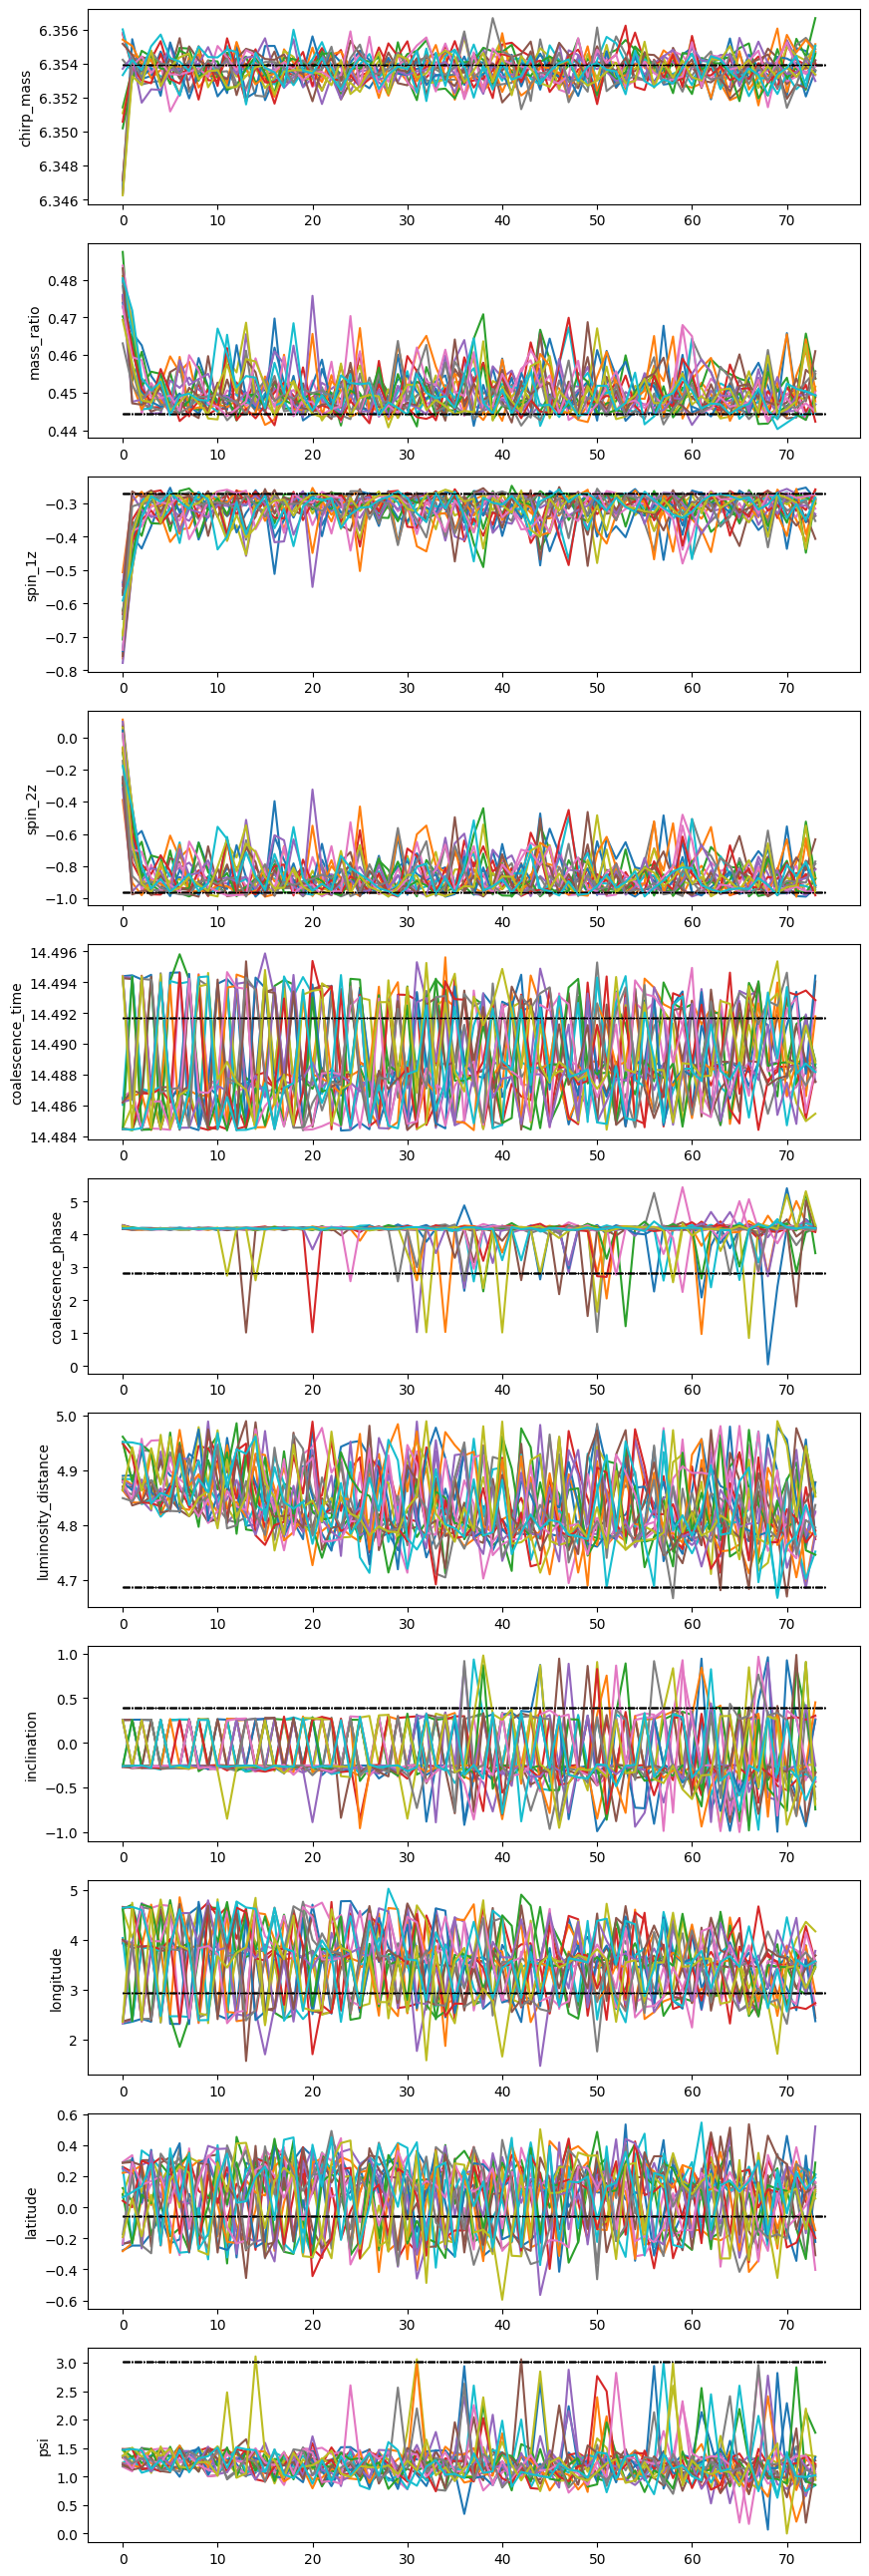

In [ ]:
thin = 10
burnin = 0
len_chain = len(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, 0, :, 0])

plt.figure()
fig, ax = plt.subplots(ndim, 1)
fig.set_size_inches(10, 3*ndim)
for i in range(ndim):     
    for walk in range(20): # plot 20 walkers 
        ax[i].plot(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, walk, 0, i])
        ax[i].hlines(ground_truths[i], 0, len_chain, color='k', linestyle='-.', linewidth=0.8)
    ax[i].set_ylabel(labels[i])
# plt.savefig("MCMC_trajectory_het.jpg", dpi=360)

sample shape: (21600, 11)


<Figure size 640x480 with 0 Axes>

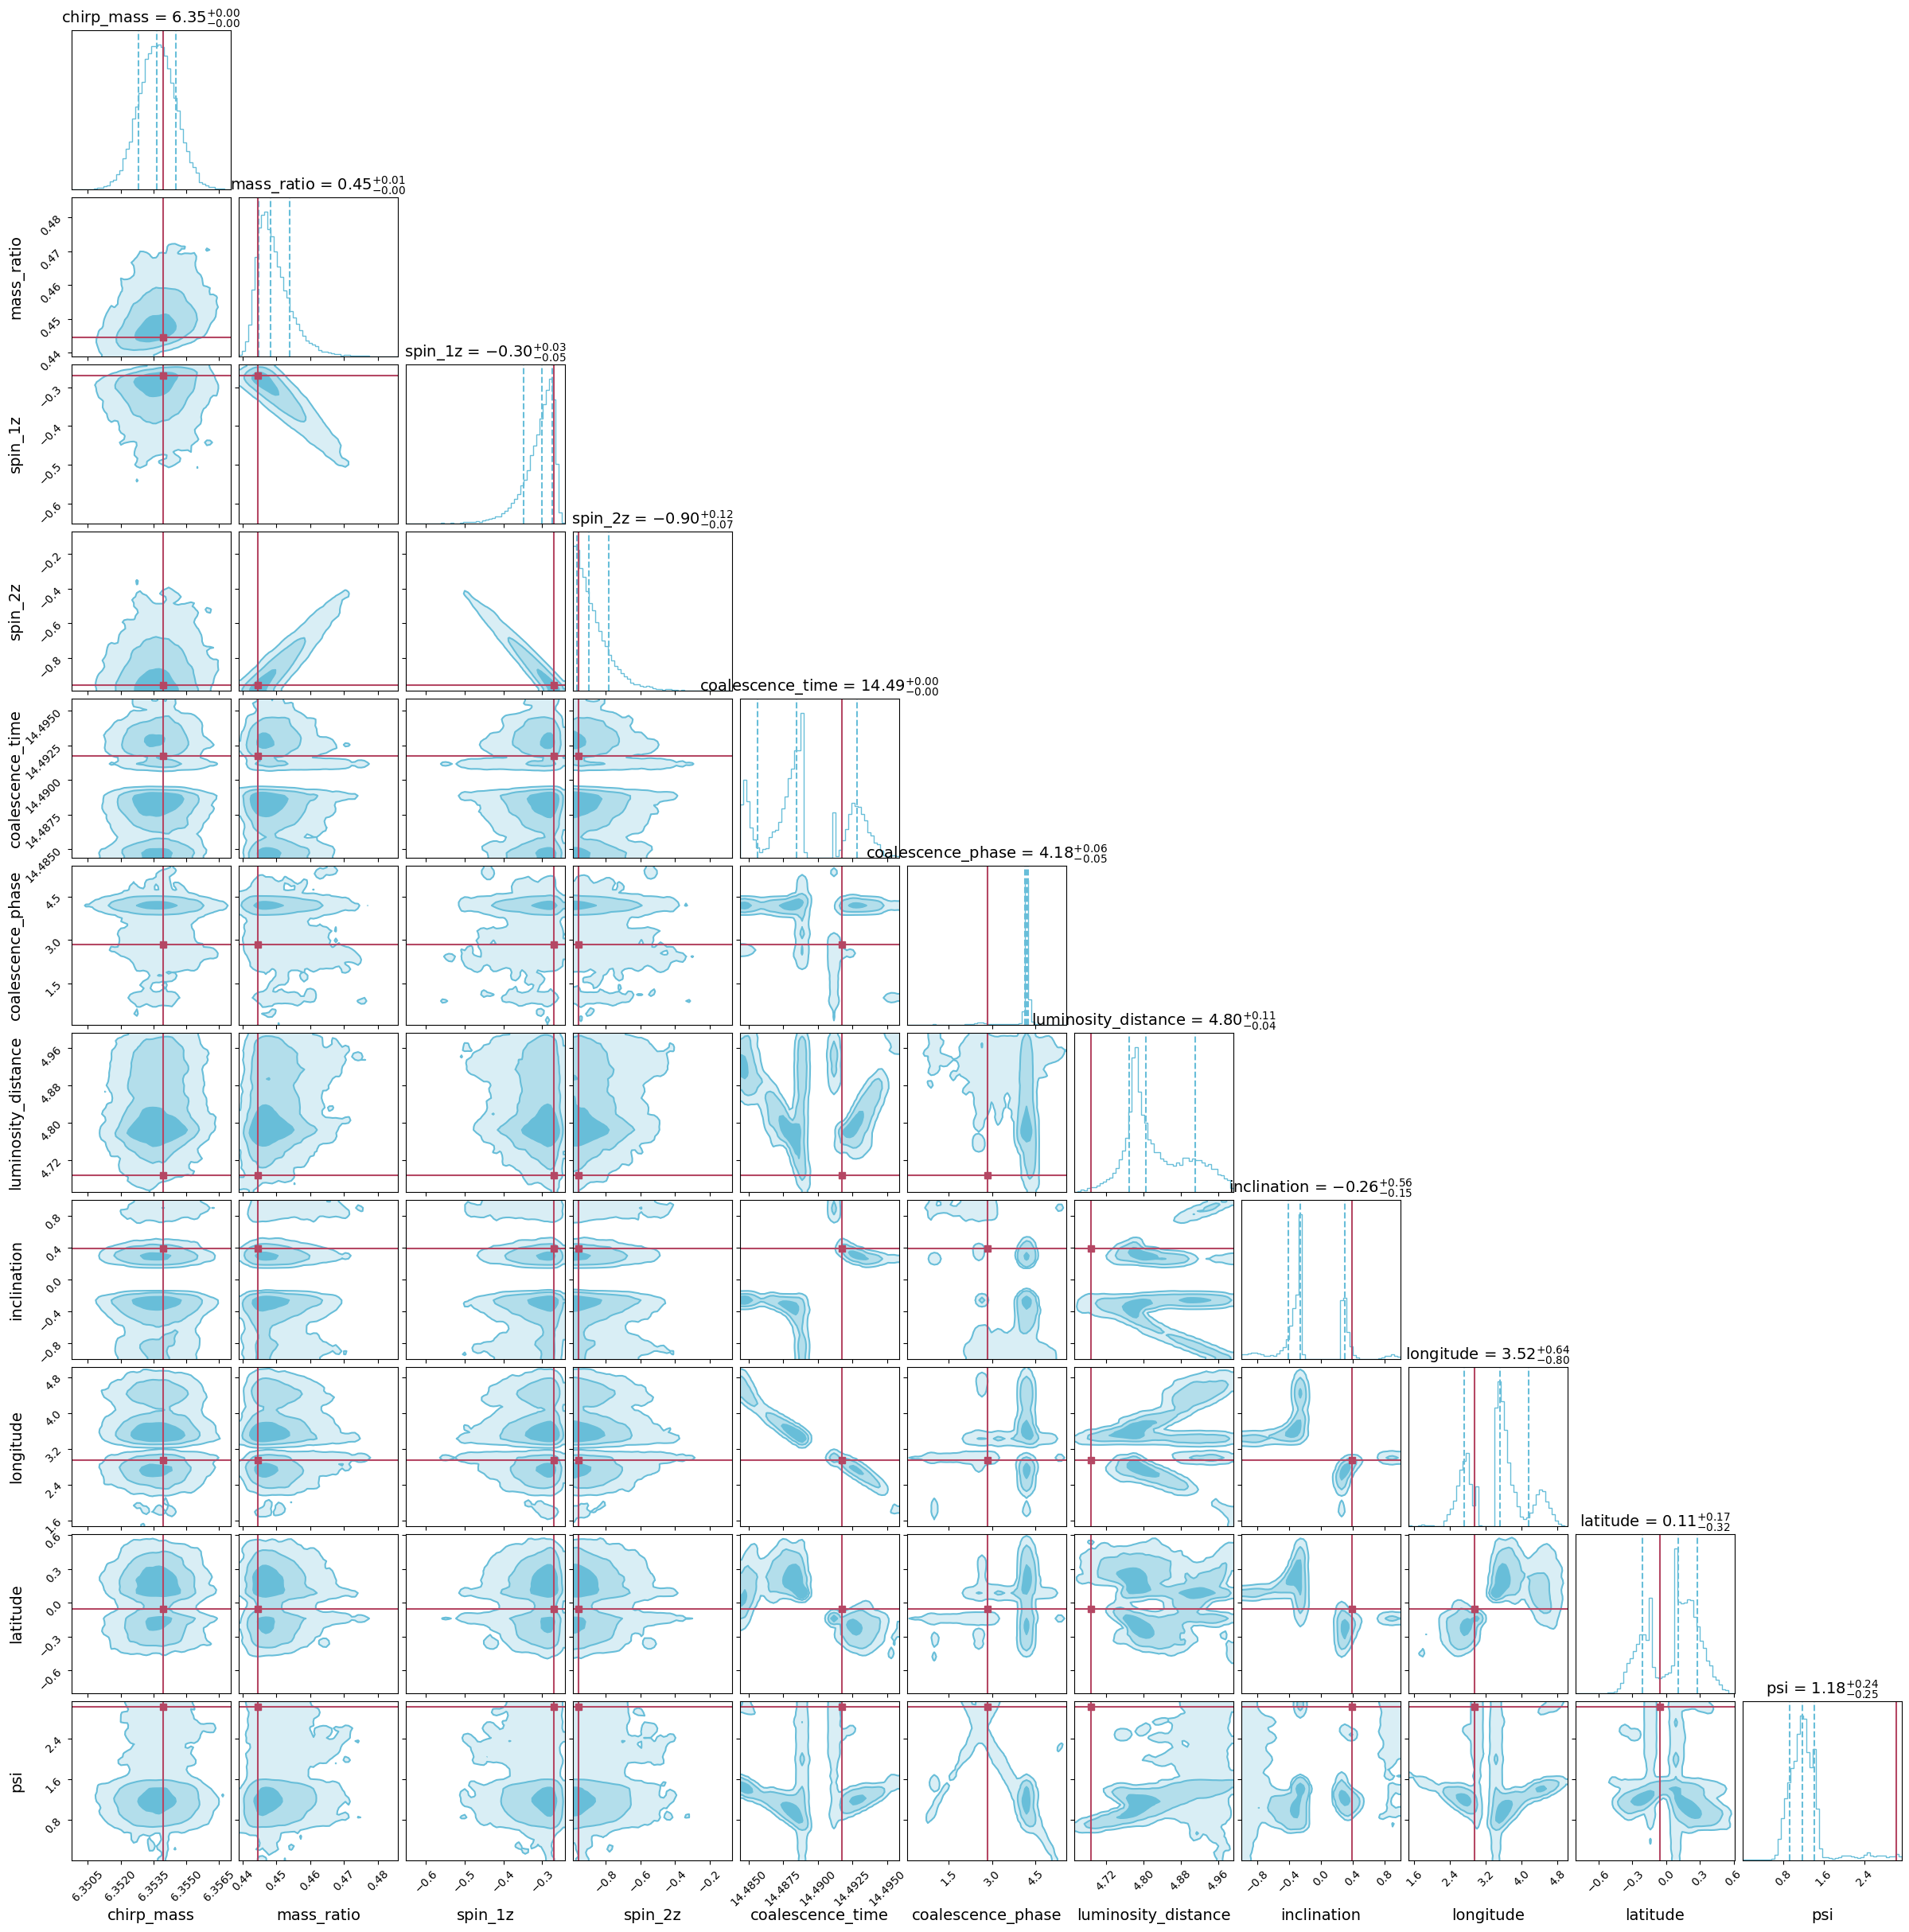

In [ ]:
burnin=200
thin = 10

samp = ensemble.get_chain(discard=burnin, thin=thin)['model_0'][:, 0, :, :, :].reshape(-1, ndim)
print("sample shape:", samp.shape)

plt.figure()
corner(
    samp, bins=50, color=BLUE, 
    labels=labels, label_kwargs={'fontsize': 14}, 
    # range=lims,
    truths=ground_truths, truth_color=RED, 
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={'fontsize':14},
    levels = (1. - np.exp(-1.**2/2), 1. - np.exp(-2.**2/2), 1. - np.exp(-3.**2/2)),
    smooth=0.9, # default for bilby: smooth = 0.9, bins = 50 
    plot_density=True, # whether to show the density of samples with colors 
    plot_datapoints=False, # whether to plot individual data points 
    fill_contours=True, # whether to fill the corners 
    );
# plt.savefig("MCMC_corner_het.jpg", dpi=360)
# np.save("chain_het.npy", samp)

In [ ]:
truths - ground_truths

array([-5.34149994e-04, -1.28270764e-03,  4.98076736e-03, -3.01885208e-02,
       -1.58564105e-03, -2.36151107e+00, -5.04816745e-01, -2.37838454e-01,
        2.75808123e-01, -1.01992837e-01, -2.69448383e+00])